# Dataset loading

Download dataset partitions.

In [ ]:
!gdown https://drive.google.com/file/d/1aQ_mpyoxlQ2OgJ7vXkPk04sogAIpbyNF/view?usp=sharing --fuzzy
!gdown https://drive.google.com/file/d/1-1bTtmmSau_o4MHBqT_FizS0-x_TwH4z/view?usp=sharing --fuzzy
!gdown https://drive.google.com/file/d/1-4T8FSnJK0PZmOuwS295BTg68lA5Q49-/view?usp=sharing --fuzzy
!gdown https://drive.google.com/file/d/1-7gXamdIWTDISiyOu40bd0xCfg1Q4a-O/view?usp=sharing --fuzzy
!gdown https://drive.google.com/file/d/1-8A598Uqj2RV705DaFF5HdM2X12bowFx/view?usp=sharing --fuzzy

Mounted at /content/gdrive


Define loading paths.

In [ ]:
tf_records_path = '/content/split_{}.record'

# Dataset decoding

Define a set of decoding functions.

In [ ]:
import tensorflow as tf
import numpy as np

def load_tf_records(filepath):
    filenames = tf.io.gfile.glob(filepath)
    dataset = tf.data.TFRecordDataset(filenames,num_parallel_reads=tf.data.experimental.AUTOTUNE)
    return dataset

def tf_records_file_features_description():
    image_feature_description = {
        
        'image/height': tf.io.FixedLenFeature([], tf.int64),
        'image/width': tf.io.FixedLenFeature([], tf.int64),
        'image': tf.io.FixedLenFeature([],tf.string),
        'label/P': tf.io.FixedLenFeature([], tf.float32),
        'label/K': tf.io.FixedLenFeature([], tf.float32),
        'label/Mg': tf.io.FixedLenFeature([], tf.float32),
        'label/Ph': tf.io.FixedLenFeature([], tf.float32),
    }
    return image_feature_description

def decode_dataset(example_proto):
    features=tf.io.parse_single_example(example_proto, tf_records_file_features_description())

    image=features['image']
    height=features['image/height']
    width=features['image/width']
    image=tf.io.decode_raw(image,tf.int16)
    image=tf.reshape(image,[height,width,150])

    P=features['label/P']
    K=features['label/K']
    Mg=features['label/Mg']
    Ph=features['label/Ph']

    height=features['image/height']
    width=features['image/width']

    label=[P,K,Mg,Ph]

    return image, label, height, width

#Dataset analysis
We will use the tf.data.datest API 

It is not required to run this section to train the model.

Load train and test datasets.

In [ ]:
# Load dataset partitions

splits = [load_tf_records(tf_records_path.format(i)).map(decode_dataset, num_parallel_calls=tf.data.AUTOTUNE) for i in range(1,6)]

Concatenate dataset partitions for analysis purposes.

In [ ]:
full_dataset = splits[0].concatenate(splits[1]).concatenate(splits[2]).concatenate(splits[3]).concatenate(splits[4])

Show dataset sizes.

In [ ]:
#[len(list(partition)) for partition in splits] #High RAM usage
num_images = [346, 346, 346, 347, 347]
print('Number of images in each partition: ', num_images)
total_num_images = sum(num_images)
print('Total number of images: ', total_num_images)

Number of images in each partition:  [346, 346, 346, 347, 347]
Total number of images:  1732


Find maximum and minimum intensity values for both datasets.

In [ ]:
# Find maximum reflectance

def find_max(dataset):                      
    max = 0
    for image, label, height, width in dataset:
        max_reflectance = np.amax(image)
        if max_reflectance > max:
            max = max_reflectance
    return(max)

# Find minimum reflectance

def find_min(dataset, min):
    for image, label, height, width in dataset:
        min_reflectance = np.amin(image)
        if min_reflectance < min:
            min = min_reflectance
    return(min)

In [ ]:
max_reflectance_overall = find_max(full_dataset)
min_reflectance_overall = find_min(full_dataset, max_reflectance_overall)
print('Max reflectance overall:', max_reflectance_overall)
print('Min reflectance overall:', min_reflectance_overall)

Max reflectance overall: 5419
Min reflectance overall: -3


Find maximum height and width of images in both datasets.

In [ ]:
shape_data = np.array(list(full_dataset.map(lambda image, label, height, width: tf.shape(image)[0:2]).as_numpy_iterator()))
h_dims, w_dims = np.hsplit(shape_data, 2)

max_height = np.amax(h_dims)
max_width = np.amax(w_dims)
print('Max height train:', max_height)
print('Max width train:', max_width)

Max height train: 268
Max width train: 284


Show image size distribution in a bar chart.

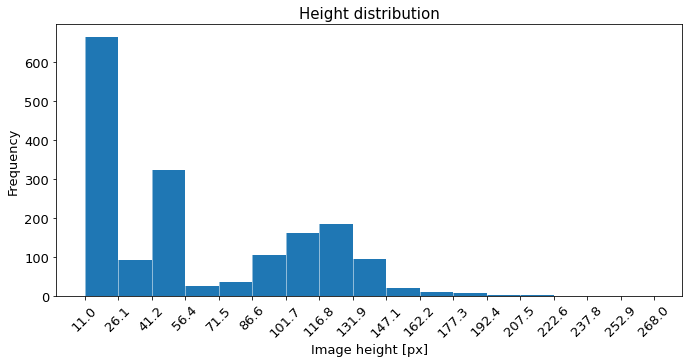

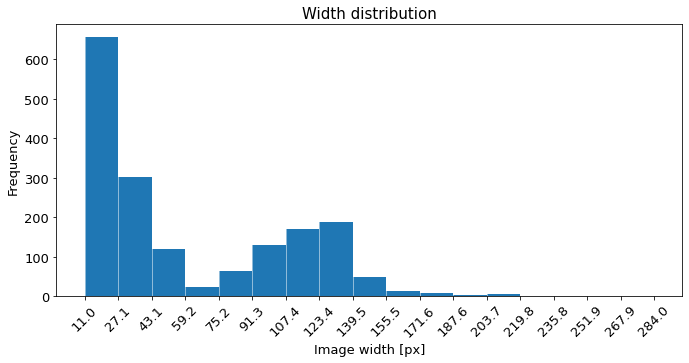

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 1, figsize=(12,5))

plt.subplots_adjust(wspace=0.1, hspace=0.4, right=0.85)

n_h, bins_h, patches_h = axs.hist(h_dims, bins='auto')
axs.set_title('Height distribution')
axs.set_xlabel('Image height [px]')
axs.set_ylabel('Frequency')
axs.set_xticks(bins_h)
axs.grid(color='white', lw = 0.5, axis='x')
axs.title.set_size(15)
axs.xaxis.label.set_size(13)
axs.yaxis.label.set_size(13)
axs.tick_params(axis='x', labelrotation=45, labelsize=13)
axs.tick_params(axis='y', labelsize=13)

fig, axs = plt.subplots(1, 1, figsize=(12,5))

plt.subplots_adjust(wspace=0.1, hspace=0.4, right=0.85)

n_w, bins_w, patches_w = axs.hist(w_dims, bins='auto')
axs.set_title('Width distribution')
axs.set_xlabel('Image width [px]')
axs.set_ylabel('Frequency')
axs.set_xticks(bins_w)
axs.grid(color='white', lw = 0.5, axis='x')
axs.title.set_size(15)
axs.xaxis.label.set_size(13)
axs.yaxis.label.set_size(13)
axs.tick_params(axis='x', labelrotation=45, labelsize=13)
axs.tick_params(axis='y', labelsize=13)

plt.show()

Calculate the average, median and standard deviation for the ground truth values.

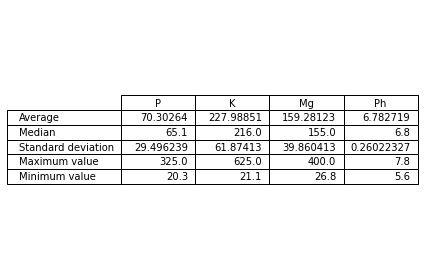

In [ ]:
# Calculate average, median and standard deviation for ground truth values

import pandas as pd

gt_data = np.array(list((full_dataset.map(lambda image, label, height, width: label)).as_numpy_iterator()))

gt_avg = np.mean(gt_data, axis=0)
gt_median = np.median(gt_data, axis=0)
gt_std = np.std(gt_data, axis=0)
gt_max = np.amax(gt_data, axis=0)
gt_min = np.amin(gt_data, axis=0)
gt_stats = np.append([gt_avg], [gt_median, gt_std, gt_max,gt_min], axis=0)

fig, ax = plt.subplots()
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

df=pd.DataFrame(gt_stats, columns=['P', 'K', 'Mg', 'Ph'],)

ax.table(cellText=df.values, colLabels=df.columns, rowLabels=['Average', 'Median', 'Standard deviation', 'Maximum value','Minimum value'], loc='center')

fig.tight_layout()

plt.show()

Find baseline mse in order to later define evaluation metrics.

In [ ]:
mse_baseline = np.mean((gt_data-gt_avg)**2, axis=0)
print(mse_baseline)

[8.7002814e+02 3.8284080e+03 1.5888525e+03 6.7716144e-02]


Print some entries.

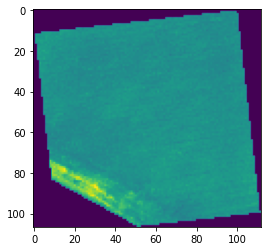

[ 85.5 234.  152.    6.9]


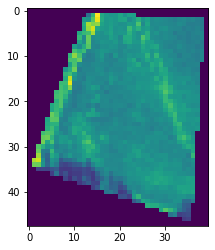

[ 76.6 351.  165.    6.9]


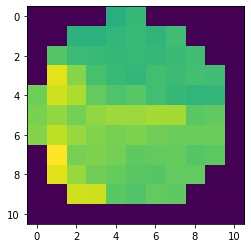

[123.  255.  175.    7.3]


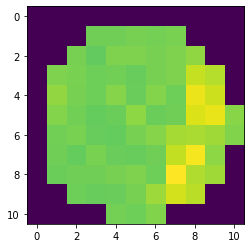

[ 65.4 283.  247.    6.8]


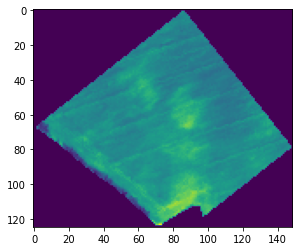

[ 75.  197.  157.    6.5]


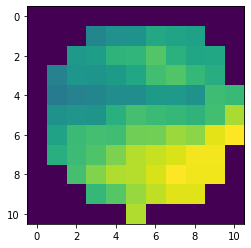

[ 37.  178.  228.    6.9]


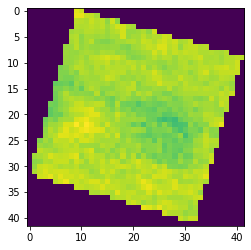

[ 62.  171.  137.    6.9]


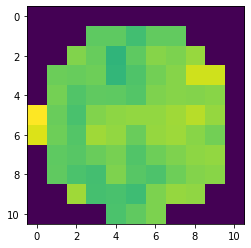

[104.  173.  139.    6.6]


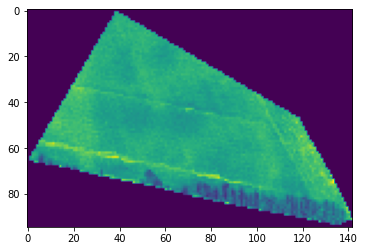

[ 74.7 181.  122.    6.7]


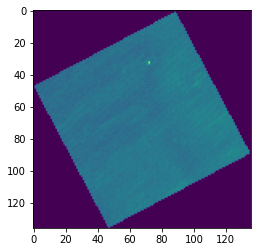

[ 46.6 176.  213.    6.7]


In [ ]:
for image, label, height, width in full_dataset.take(10):
  plt.imshow(image[:,:,1].numpy())
  plt.show()
  print(label.numpy())


# Dataset preprocessing

In [7]:
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
import pandas as pd
import os
import random as rn
import numpy as np
import tensorflow as tf

rn.seed(2)
np.random.seed(3)
tf.random.set_seed(1)

AUTO = tf.data.AUTOTUNE 

Define preprocessing values.

In [9]:
max_reflectance_overall = 5419

max_height = 268
max_width = 284

total_num_images = 1732
num_images = [346, 346, 346, 347, 347]

max_gt_values = [325, 625, 400, 14]

mse_baseline = [8.7002814e+02, 3.8284080e+03, 1.5888525e+03, 6.7716144e-02]

!gdown https://drive.google.com/file/d/12NScF4TLmZXx2oo-hfEfbkqgi6IYMmiO/view?usp=sharing --fuzzy
std_vec = tf.cast(tf.reshape(np.load('/content/std_vector.npy'), [150]), dtype='float32')

Downloading...
From: https://drive.google.com/uc?id=12NScF4TLmZXx2oo-hfEfbkqgi6IYMmiO
To: /content/std_vector.npy
100% 1.33k/1.33k [00:00<00:00, 1.81MB/s]


Define normalization and augmentation functions for the train set.

In [10]:
target_image_size = 32

def normalize_train(image,label, height, width, std_vec, max_gt_values):    #Function to normalize the train dataset
    
    image = tf.cast(image,tf.float32)
    image = image/std_vec
    label /= max_gt_values

    return image, label, height, width

def make_horizontal_patch_train(patch, nx):    #Function that repeats a patch horizontally with random flips
    
    hor_patch = tf.image.random_flip_left_right(tf.image.random_flip_up_down(patch, seed=72), seed=64)
    i=0

    def cond(hor_patch, patch, i, nx):
        return tf.less(i, nx-1)
    def body(hor_patch, patch, i, nx):
        hor_patch = tf.concat([hor_patch, tf.image.random_flip_left_right(tf.image.random_flip_up_down(patch, seed=49), seed=95)], 1)
        i+=1
        return hor_patch, patch, i, nx

    hor_patch, _, _, _ = tf.while_loop(cond, body, [hor_patch, patch, i, nx])

    return hor_patch

def image_repetition_train(image, height, width):    #Function that repeats small images applying random flips to create a bigger image
    
    nx = tf.math.floordiv(target_image_size, tf.cast(width, tf.int32))
    ny = tf.math.floordiv(target_image_size, tf.cast(height, tf.int32))
    patch = image
    image = make_horizontal_patch_train(patch, nx)
    i=0

    def cond(image, patch, i, ny):
        return tf.less(i, ny-1)
    def body(image, patch, i, ny):
        image = tf.concat([image, make_horizontal_patch_train(patch, nx)], 0)
        i+=1
        return image, patch, i, ny
    
    image, _, _, _= tf.while_loop(cond, body, [image, patch, i, ny])

    image = tf.cond(tf.math.maximum(nx, ny)==1, lambda: tf.image.resize(image, [target_image_size, target_image_size], method='bilinear', antialias=False), lambda: tf.image.pad_to_bounding_box(image, 0, 0, target_image_size, target_image_size))

    return image

def pad_with_patches_train(image, label, height, width):    #Function to resize images to [32,32,150]
    
    max_dim = tf.math.maximum(height, width)
    image = tf.cond(max_dim<target_image_size, lambda: image_repetition_train(image, height, width), lambda: tf.image.resize(image, [target_image_size, target_image_size], method='bilinear', antialias=False))
    image = add_gauss_noise(image)

    index=tf.random.uniform(shape=[],maxval=4,dtype=tf.dtypes.int32,seed=32)
    
    image=tf.cond(tf.equal(index,1),lambda: tf.image.flip_left_right(image), lambda: image)

    image=tf.cond(tf.equal(index,2),lambda: tf.image.flip_up_down(image), lambda: image)

    image=tf.cond(tf.equal(index,3),lambda: tf.image.flip_left_right(tf.image.flip_up_down(image)), lambda: image)

    return image, label

def add_gauss_noise(image):
  
    mean = 0
    std = 0.05
      
    gauss = tf.random.normal([target_image_size, target_image_size, 150], mean, std, seed=910)

    noisy = image + gauss

    return noisy

Training setup.

In [11]:
# Any number in [1,5]
test_partition_id = 5
num_train_images = total_num_images - num_images[test_partition_id-1]

epochs = 400
batch_size = 32
steps_per_epoch = num_train_images//batch_size

Dataset mapping (tf.data.Dataset API).

In [ ]:
# Concatenate partitions to form the train set, the chosen test partition is excluded
splits = [load_tf_records(tf_records_path.format(i)).map(decode_dataset, num_parallel_calls=tf.data.AUTOTUNE) for i in range(1,6)]
index = list(range(5))
index.pop(test_partition_id-1)

ds = splits[index[0]]
index.pop(0)

for i in index:
    ds = ds.concatenate(splits[i])


# Train
train_data = ds.take(1376)
train_data = train_data.map(lambda image, label, height, width: normalize_train(image, label, height, width, std_vec, max_gt_values), num_parallel_calls=AUTO).cache()    #normalize train dataset
train_data = train_data.shuffle(num_train_images, seed=1866)    #shuffle train dataset
train_data = train_data.map(lambda image, label, height, width: pad_with_patches_train(image, label, height, width), num_parallel_calls=AUTO)    #pad test dataset
train_data = train_data.batch(batch_size=batch_size, drop_remainder=True)    #batch train dataset
train_data = train_data.prefetch(AUTO)    #prefetch train dataset

# Validation
val_data = ds.skip(1376)    #create validation dataset from the last elements of the train dataset that are discarded during batching
val_data = val_data.map(lambda image, label, height, width: normalize_train(image, label, height, width, std_vec, max_gt_values), num_parallel_calls=AUTO).cache()    #normalize validation dataset 
val_data = val_data.map(lambda image, label, height, width: pad_with_patches_train(image, label, height, width), num_parallel_calls=AUTO)    #pad validation dataset
val_data = val_data.batch(batch_size=10, drop_remainder=False)    #batch validation dataset
val_data = val_data.prefetch(AUTO)    #prefetch validation dataset

Print some training images.

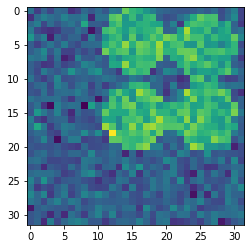

[0.168  0.3424 0.595  0.5   ]


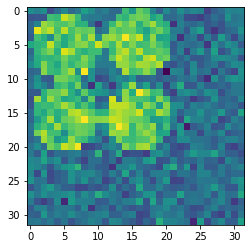

[0.20584616 0.2816     0.2875     0.5214286 ]


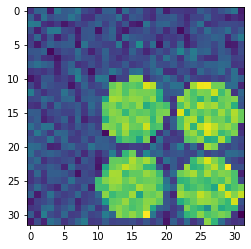

[0.41230768 0.3648     0.4775     0.4642857 ]


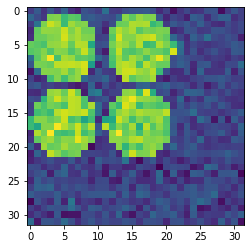

[0.168     0.304     0.325     0.5142857]


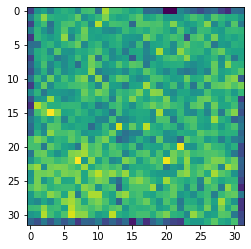

[0.10184615 0.2624     0.455      0.45000002]


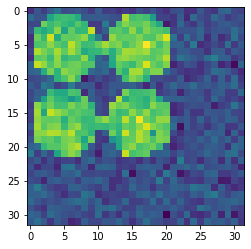

[0.1516923  0.3872     0.3275     0.50928575]


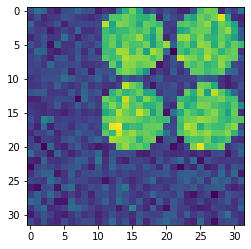

[0.18523078 0.2896     0.18450001 0.47142857]


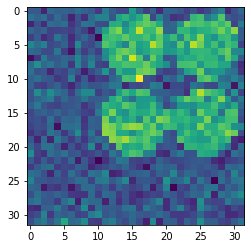

[0.12707692 0.3872     0.615      0.4642857 ]


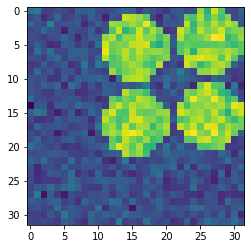

[0.17507693 0.3824     0.5375     0.5       ]


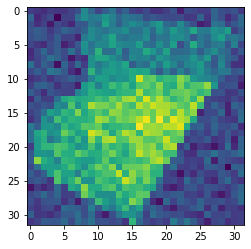

[0.21599999 0.3904     0.3725     0.47857141]


In [ ]:
for image, label in train_data.unbatch().take(10):
        plt.imshow(image[:,:,149])
        plt.show()
        print(label.numpy())  

Print the validation set.

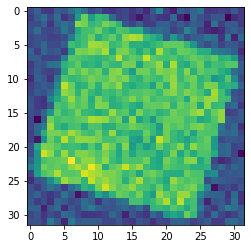

[0.20799999 0.3776     0.3        0.47142857]


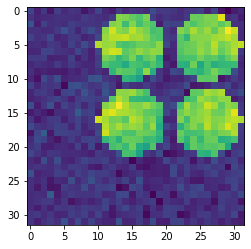

[0.32       0.5536     0.5025     0.50714284]


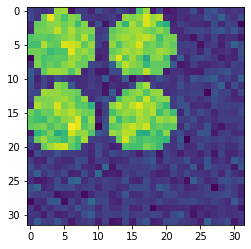

[0.18830769 0.36       0.5625     0.5       ]


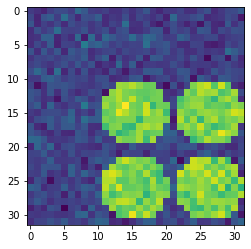

[0.17507693 0.3104     0.44       0.5       ]


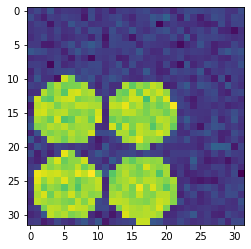

[0.21692307 0.3712     0.345      0.5214286 ]


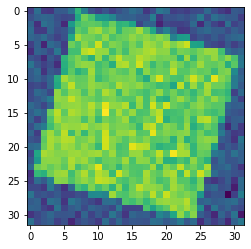

[0.23815385 0.3648     0.2875     0.47857141]


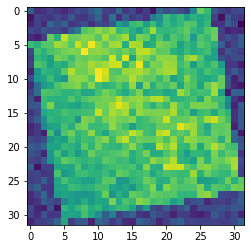

[0.32923076 0.4224     0.3575     0.47857141]


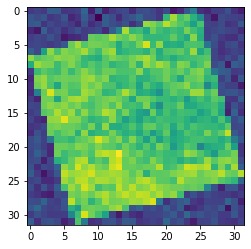

[0.17138462 0.336      0.2975     0.45000002]


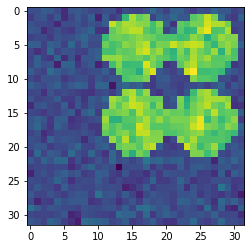

[0.13046154 0.304      0.3925     0.48785713]


In [ ]:
for image, label in val_data.unbatch():
        plt.imshow(image[:,:,0])
        plt.show()
        print(label.numpy())

# Build and train NN model
EdgeNeXt_XX_Small: the following cell is adapted from https://github.com/leondgarse/keras_cv_attention_models/tree/main/keras_cv_attention_models/edgenext, distributed under MIT License.

A new EdgeNeXt verison is defined by changing the Downsampling and Conv. Encoder kernel size to 2x2 and 3x3 respectively. The last layer Dense layer is set to have only 4 nodes and no activation.

In [4]:
!pip install -U keras-cv-attention-models --quiet

import tensorflow as tf
from tensorflow import keras
from keras_cv_attention_models.attention_layers import (
    ChannelAffine,
    activation_by_name,
    conv2d_no_bias,
    depthwise_conv2d_no_bias,
    drop_block,
    layer_norm,
    mlp_block,
    multi_head_self_attention,
    output_block,
    add_pre_post_process,
    PositionalEncodingFourier
)
from keras_cv_attention_models.download_and_load import reload_model_weights

PRETRAINED_DICT = {
    "edgenext_small": {"imagenet": {256: "0234641a703283de1cb0d935bb0325e4"}},
    "edgenext_small": {"usi": {256: "c237761b5bd5c32041d6b758186a0716"}},
    "edgenext_x_small": {"imagenet": {256: "472df7659422c7feffbec8012a0f6fa4"}},
    "edgenext_xx_small": {"imagenet": {256: "4190ba28c7caa2fe73215448f8abebd6"}},
}
LAYER_NORM_EPSILON = 1e-6

def norm_inverted_bottleneck(inputs, mlp_ratio=4, layer_scale=1e-6, drop_rate=0, activation="gelu", name=""):
    input_channel = inputs.shape[-1]
    nn = layer_norm(inputs, epsilon=LAYER_NORM_EPSILON, name=name)
    nn = mlp_block(nn, input_channel * mlp_ratio, activation=activation, name=name)
    nn = ChannelAffine(use_bias=False, weight_init_value=layer_scale, name=name + "gamma")(nn) if layer_scale >= 0 else nn
    nn = drop_block(nn, drop_rate=drop_rate, name=name)
    return nn


def cross_covariance_attention(inputs, num_heads=4, key_dim=0, qkv_bias=True, out_bias=True, attn_dropout=0, out_dropout=0, name=None):
    input_channel = inputs.shape[-1]
    key_dim = key_dim if key_dim > 0 else input_channel // num_heads
    qk_out = key_dim * num_heads

    qkv = keras.layers.Dense(qk_out * 3, use_bias=True, name=name and name + "qkv")(inputs)
    qkv = tf.reshape(qkv, [-1, qkv.shape[1] * qkv.shape[2], qkv.shape[-1]])
    query, key, value = tf.split(qkv, 3, axis=-1)
    query = tf.transpose(tf.reshape(query, [-1, query.shape[1], num_heads, key_dim]), [0, 2, 3, 1])  #  [batch, num_heads, key_dim, hh * ww]
    key = tf.transpose(tf.reshape(key, [-1, key.shape[1], num_heads, key_dim]), [0, 2, 1, 3])  # [batch, num_heads, hh * ww, key_dim]
    value = tf.transpose(tf.reshape(value, [-1, value.shape[1], num_heads, key_dim]), [0, 2, 3, 1])  # [batch, num_heads, key_dim, hh * ww]

    norm_query, norm_key = tf.nn.l2_normalize(query, axis=-1, epsilon=1e-6), tf.nn.l2_normalize(key, axis=-2, epsilon=1e-6)
    attn = tf.matmul(norm_query, norm_key)  # [batch, num_heads, key_dim, key_dim]
    attn = ChannelAffine(axis=1, use_bias=False, name=name and name + "temperature/no_weight_decay")(attn)  # axis=1 means on head dimension
    attention_scores = keras.layers.Softmax(axis=-1, name=name and name + "attention_scores")(attn)

    if attn_dropout > 0:
        attention_scores = keras.layers.Dropout(attn_dropout, name=name and name + "attn_drop")(attention_scores)
    # [batch, num_heads, key_dim, key_dim] * [batch, num_heads, key_dim, hh * ww] -> [batch, num_heads, key_dim, hh * ww]
    attention_output = tf.matmul(attention_scores, value)
    attention_output = tf.transpose(attention_output, perm=[0, 3, 1, 2])  # [batch, hh * ww, num_heads, key_dim]
    attention_output = tf.reshape(attention_output, [-1, inputs.shape[1], inputs.shape[2], num_heads * key_dim])  # [batch, hh, ww, num_heads * key_dim]
    # print(f">>>> {attention_output.shape = }, {attention_scores.shape = }")

    # [batch, hh, ww, num_heads * key_dim] * [num_heads * key_dim, out] --> [batch, hh, ww, out]
    attention_output = keras.layers.Dense(qk_out, use_bias=out_bias, name=name and name + "output")(attention_output)
    attention_output = keras.layers.Dropout(out_dropout, name=name and name + "out_drop")(attention_output) if out_dropout > 0 else attention_output
    return attention_output


def split_depthwise_transpose_attention(
    inputs, split=1, num_heads=4, mlp_ratio=4, use_pos_emb=False, layer_scale=1e-6, drop_rate=0, activation="gelu", name=""
):
    input_channel = inputs.shape[-1]
    sub_channels = int(tf.math.ceil(input_channel / split))

    spx, remainder = inputs[:, :, :, : (split - 1) * sub_channels], inputs[:, :, :, (split - 1) * sub_channels :]
    spx = tf.split(spx, split - 1, axis=-1)
    gathered_result = []
    for id, ii in enumerate(spx):
        sp = ii if id == 0 else (sp + ii)
        sp = depthwise_conv2d_no_bias(sp, kernel_size=3, padding="SAME", use_bias=True, name=name + "spx_{}_".format(id + 1))
        gathered_result.append(sp)
    gathered_result.append(remainder)
    attn = tf.concat(gathered_result, axis=-1)
    # print(f"{inputs.shape = }, {attn.shape = }")

    # XCA
    attn = PositionalEncodingFourier(name=name + "pos")(attn) if use_pos_emb else attn
    nn = layer_norm(attn, epsilon=LAYER_NORM_EPSILON, name=name + "xca_")
    nn = cross_covariance_attention(nn, num_heads, name=name + "xca_")
    nn = ChannelAffine(use_bias=False, weight_init_value=layer_scale, name=name + "xca_gamma")(nn) if layer_scale >= 0 else nn
    nn = drop_block(nn, drop_rate=drop_rate, name=name + "xca_")
    nn = keras.layers.Add(name=name + "xca")([attn, nn])

    # Inverted Bottleneck
    nn = norm_inverted_bottleneck(nn, mlp_ratio, layer_scale, drop_rate, activation=activation, name=name + "ir_")
    return keras.layers.Add(name=name + "output")([inputs, nn])


def conv_encoder(inputs, mlp_ratio=4, kernel_size=7, layer_scale=1e-6, drop_rate=0, activation="gelu", name=""):
    input_channel = inputs.shape[-1]
    nn = depthwise_conv2d_no_bias(inputs, kernel_size, use_bias=True, padding="SAME", name=name)
    nn = norm_inverted_bottleneck(nn, mlp_ratio, layer_scale, drop_rate, activation=activation, name=name)
    # print(f"{nn.shape = }, {inputs.shape = }")
    return keras.layers.Add(name=name + "output")([inputs, nn])


def EdgeNeXt(
    num_blocks=[2, 2, 6, 2],
    out_channels=[24, 48, 88, 168],
    num_heads=4,
    num_stda_layers=[0, 1, 1, 1],
    stda_split=[2, 2, 3, 4],
    stda_use_pos_emb=[False, True, False, False],
    conv_kernel_size=[3, 3, 3, 3],
    stem_width=-1,
    mlp_ratio=4,
    stem_patch_size=2,
    layer_scale=1e-6,
    input_shape=(224, 224, 3),
    num_classes=1000,
    activation="gelu",
    drop_connect_rate=0,
    classifier_activation="softmax",
    dropout=0,
    pretrained=None,
    model_name="edgenext",
    kwargs=None,
):
    inputs = keras.layers.Input(input_shape)
    stem_width = stem_width if stem_width > 0 else out_channels[0]
    nn = conv2d_no_bias(inputs, stem_width, kernel_size=stem_patch_size, strides=stem_patch_size, use_bias=True, padding="VALID", name="stem_")
    nn = layer_norm(nn, epsilon=LAYER_NORM_EPSILON, name="stem_")

    """ stages """
    total_blocks = sum(num_blocks)
    global_block_id = 0
    for stack_id, (num_block, out_channel, num_stda_layer) in enumerate(zip(num_blocks, out_channels, num_stda_layers)):
        stack_name = "stack{}_".format(stack_id + 1)
        if stack_id > 0:
            ds_name = stack_name + "downsample_"
            nn = layer_norm(nn, epsilon=LAYER_NORM_EPSILON, name=ds_name)
            # Set use_torch_padding=False, as kernel_size == 2, otherwise shape will be enlarged by 1
            nn = conv2d_no_bias(nn, out_channel, kernel_size=2, strides=2, use_bias=True, padding="VALID", name=ds_name)
        for block_id in range(num_block):
            block_name = stack_name + "block{}_".format(block_id + 1)
            block_drop_rate = drop_connect_rate * global_block_id / total_blocks
            if block_id > num_block - num_stda_layer - 1:
                split = stda_split[stack_id]
                use_pos_emb = stda_use_pos_emb[stack_id]
                num_head = num_heads[stack_id] if isinstance(num_heads, (list, tuple)) else num_heads
                nn = split_depthwise_transpose_attention(
                    nn, split, num_head, mlp_ratio, use_pos_emb, layer_scale, block_drop_rate, activation, name=block_name + "stda_"
                )
            else:
                kernel_size = conv_kernel_size[stack_id]
                nn = conv_encoder(nn, mlp_ratio, kernel_size, layer_scale, block_drop_rate, activation=activation, name=block_name + "conv_")
            global_block_id += 1

    """ output """
    if num_classes > 0:
        nn = keras.layers.GlobalAveragePooling2D(name="avg_pool")(nn)
        nn = layer_norm(nn, epsilon=LAYER_NORM_EPSILON, name="pre_output_")
        if dropout > 0:
            nn = keras.layers.Dropout(dropout, name="head_drop")(nn)
        nn = keras.layers.Dense(num_classes, dtype="float32", activation=classifier_activation, name="predictions")(nn)

    model = keras.models.Model(inputs, nn, name=model_name)
    add_pre_post_process(model, rescale_mode="torch")
    reload_model_weights(model, PRETRAINED_DICT, "edgenext", pretrained)
    return model


def EdgeNeXt_XXSmod(input_shape=(256, 256, 3), num_classes=1000, classifier_activation="softmax", pretrained="imagenet", **kwargs):
    return EdgeNeXt(**locals(), model_name="edgenext_xx_small", **kwargs)

Learning rate scheduling.

Learning rate per epoch:


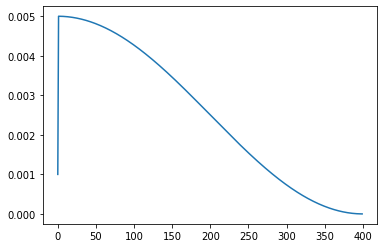

In [12]:
start_lr = 0.005 #*256/batch_size
alpha = 0.0001
decay_steps = epochs

def lr_scheduler(epoch, start_lr):
    if epoch < 1:
      lr = (start_lr-0.001)/1*epoch+0.001
    else:
      cosine_decay = 0.5 * (1 + tf.cos(np.pi * epoch / (decay_steps)))
      decayed = (1 - alpha) * cosine_decay + alpha
      lr = start_lr * decayed
    return lr

lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lr_scheduler(epoch, start_lr), verbose=1)

#Plot learning rate

x_range = np.arange(epochs)
y = [lr_scheduler(x, start_lr) for x in x_range]
plt.plot(x_range, y)
print('Learning rate per epoch:')

Compile the model.

In [13]:
network_name = 'EdgeNeXt_GPU_32px_cross_validation'

model = EdgeNeXt_XXSmod(input_shape = (32, 32, 150), num_classes = 4, classifier_activation = None, pretrained='None')

def custom_metric(y_true, y_pred):
    y_true = tf.multiply(y_true, max_gt_values)
    y_pred = tf.multiply(y_pred, max_gt_values)
    mse = tf.reduce_mean((y_true-y_pred)**2, axis=0)
    score = tf.reduce_mean(mse/mse_baseline)

    return score

opt = keras.optimizers.Adam(clipnorm=1.)
model.compile(
    optimizer=opt,
    loss='mse',
    metrics=[custom_metric],
  )

model.summary()

>>>> No pretrained available, model will be randomly initialized
Model: "edgenext_xx_small"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 150  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 16, 16, 24)   14424       ['input_1[0][0]']                
                                                                                                  
 stem_ln (LayerNormalization)   (None, 16, 16, 24)   48          ['stem_conv[0][0]']              
                                                                                                  
 stack1_block1_co

Define saving paths.

In [14]:
base_path = '/content/'

checkpoint_filepath = base_path + network_name + '/model_test_partition_mod_' + str(test_partition_id) 
predictions_filepath = base_path + network_name + '/predictions_test_partition_mod_' + str(test_partition_id) + '.csv'

print(checkpoint_filepath)
print(predictions_filepath)

/content/EdgeNeXt_GPU_32px_cross_validation/model_test_partition_mod_5
/content/EdgeNeXt_GPU_32px_cross_validation/predictions_test_partition_mod_5.csv


Train the model.

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True, monitor='custom_metric', mode='min')

History = model.fit(train_data, epochs=epochs, callbacks=[lr_callback], validation_data=val_data)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/400
43/43 [==============================] - 30s 173ms/step - loss: 0.3547 - custom_metric: 175.1346 - val_loss: 0.0255 - val_custom_metric: 16.8207 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.004999923054128885.
Epoch 2/400
43/43 [==============================] - 6s 133ms/step - loss: 0.0341 - custom_metric: 17.8403 - val_loss: 0.0074 - val_custom_metric: 2.2009 - lr: 0.0050

Epoch 3: LearningRateScheduler setting learning rate to 0.004999691620469093.
Epoch 3/400
43/43 [==============================] - 6s 132ms/step - loss: 0.0095 - custom_metric: 1.9254 - val_loss: 0.0065 - val_custom_metric: 1.1045 - lr: 0.0050

Epoch 4: LearningRateScheduler setting learning rate to 0.0049993060529232025.
Epoch 4/400
43/43 [==============================] - 6s 140ms/step - loss: 0.0088 - custom_metric: 1.8207 - val_loss: 0.0051 - val_custom_metric: 0.8110 - lr: 0.0050

Epoch 5: LearningRateSchedul

Export trained model.

In [15]:
model.save(checkpoint_filepath)

Show some training info.

In [ ]:
min_metric_epoch = tf.math.argmin(History.history['custom_metric'])
min_metric = History.history['custom_metric'][min_metric_epoch]
loss_min_metric = History.history['loss'][min_metric_epoch]
val_metric = History.history['val_custom_metric'][min_metric_epoch]
val_loss = History.history['val_loss'][min_metric_epoch]

print('Best model at epoch', (min_metric_epoch.numpy() + 1))
print('Metric:', min_metric)
print('Loss:', loss_min_metric)
print('Validation metric:', val_metric)
print('Validation loss:', val_loss)

Best model at epoch 379
Metric: 0.508008599281311
Loss: 0.003228927729651332
Validation metric: 0.6073054075241089
Validation loss: 0.003848884254693985


Show training progress.

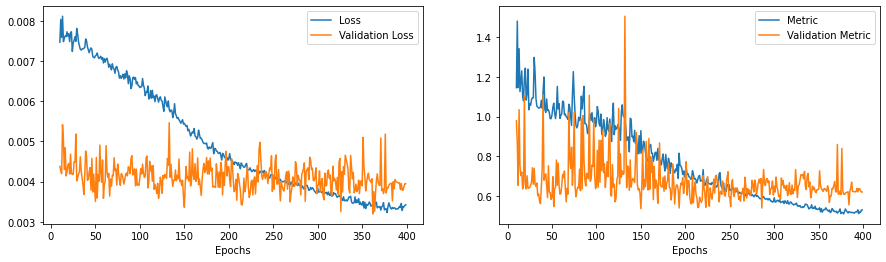

In [ ]:
start_epoch_loss = 10
epochs_interval_loss = range(start_epoch_loss, epochs)
start_epoch_metric = 10
epochs_interval_metric = range(start_epoch_metric, epochs)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))

ax1.plot(epochs_interval_loss, History.history['loss'][start_epoch_loss:], label='Loss')
ax1.plot(epochs_interval_loss, History.history['val_loss'][start_epoch_loss:], label='Validation Loss')
ax1.set_xlabel("Epochs")
ax1.legend(loc='upper right')

ax2.plot(epochs_interval_metric, History.history['custom_metric'][start_epoch_metric:], label='Metric')
ax2.plot(epochs_interval_metric, History.history['val_custom_metric'][start_epoch_metric:], label='Validation Metric')
ax2.set_xlabel("Epochs")
ax2.legend(loc='upper right')

plt.show()

# Load model and make predictions



Define test set preprocessing functions.

In [ ]:
def normalize_test(image, label, height, width, std_vec, max_gt_values):             #Function to normalize the test dataset
    image = tf.cast(image,tf.float32)
    image = image/std_vec
    label = label/max_gt_values

    return image, label, height, width

def image_repetition_test(image, height, width):    #Function that repeats small images applying random flips to create a bigger image
    nx = tf.math.floordiv(target_image_size, tf.cast(width, tf.int32))
    ny = tf.math.floordiv(target_image_size, tf.cast(height, tf.int32))
    
    image = tf.tile(image, [ny, nx, 1])
    image = tf.cond(tf.math.maximum(nx, ny)==1, lambda: tf.image.resize(image, [target_image_size, target_image_size], method='bilinear', antialias=False), lambda: tf.image.pad_to_bounding_box(image, 0, 0, target_image_size, target_image_size))

    return image

def pad_with_patches_test(image, label, height, width):    #Function to resize images to [128,128,150]
    max_dim = tf.math.maximum(height, width)
    image = tf.cond(max_dim<target_image_size, lambda: image_repetition_test(image, height, width), lambda: tf.image.resize(image, [target_image_size, target_image_size], method='bilinear', antialias=False))

    return image, label

Preprocessing of test dataset.

In [ ]:
test_data = load_tf_records(tf_records_path.format(test_partition_id)).map(decode_dataset, num_parallel_calls=AUTO)

test_data = test_data.map(lambda image, label, height, width: normalize_test(image, label, height, width, std_vec, max_gt_values), num_parallel_calls=AUTO)    #normalize test dataset
test_data = test_data.map(lambda image, label, height, width: pad_with_patches_test(image, label, height, width), num_parallel_calls=AUTO).cache()    #pad test dataset
test_data = test_data.batch(batch_size=batch_size, drop_remainder=False).prefetch(AUTO)    #batch and prefetch test dataset

Print some entries from the test dataset

[0.16707692 0.2752     0.4375     0.4642857 ]


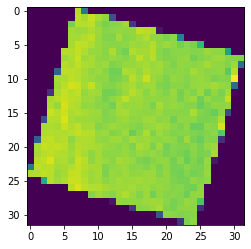

[0.24       0.4768     0.435      0.45714286]


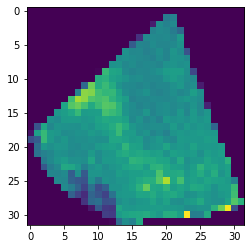

[0.35076922 0.3872     0.385      0.49428573]


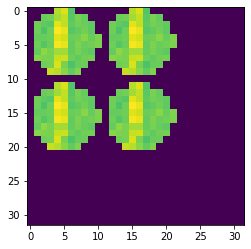

[0.15015385 0.2928     0.3625     0.47857141]


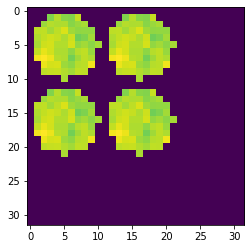

[0.23323078 0.288      0.37       0.4857143 ]


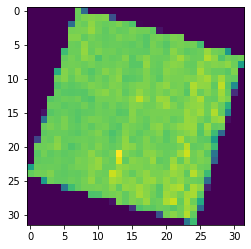

[0.20584616 0.3024     0.515      0.4857143 ]


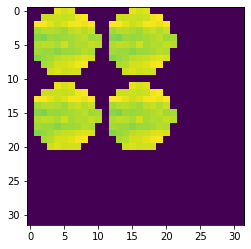

[0.08553846 0.3104     0.4825     0.4642857 ]


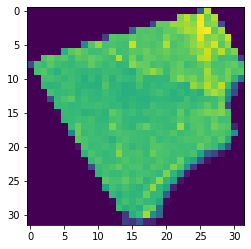

[0.3723077  0.3536     0.5025     0.45714286]


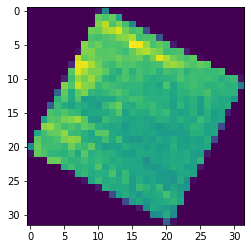

[0.16369231 0.32       0.305      0.45714286]


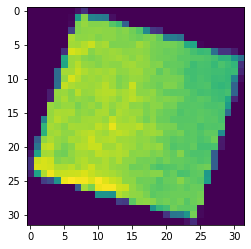

[0.31384614 0.2816     0.4525     0.47857141]


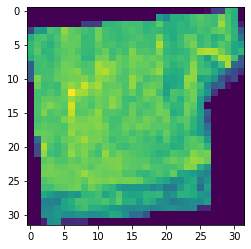

In [ ]:
for image, label in test_data.unbatch().take(10):
    plt.imshow(image[:,:,0].numpy())
    print(label.numpy())
    plt.show()
    

Load the exported model.

In [ ]:
loaded_model = keras.models.load_model(checkpoint_filepath, custom_objects={'custom_metric': custom_metric})

loaded_model.summary()

Model: "edgenext_xx_small"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 32, 32, 150  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 16, 16, 24)   14424       ['input_10[0][0]']               
                                                                                                  
 stem_ln (LayerNormalization)   (None, 16, 16, 24)   48          ['stem_conv[0][0]']              
                                                                                                  
 stack1_block1_conv_dw_pad (Zer  (None, 18, 18, 24)  0           ['stem_ln[0][0]']

Make predictions and generate csv file.

In [ ]:
predictions = loaded_model.predict(test_data)

submission = pd.DataFrame(data=predictions, columns=["P", "K", "Mg", "pH"])
submission.to_csv(predictions_filepath, index_label="sample_index")

Evaluate model performace.

In [ ]:
gt = np.array(list(test_data.unbatch().map(lambda image, label: label)))

score = custom_metric(gt, predictions)

print(score.numpy())

0.86002207
